In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Deep learning approach: TensorFlow

Ways to frame problem:

- Recover colourmap from pseudocolour, then lookup data from code book.
- Recover data from pseudocolour directly. 

## EITHER make map data...

In [672]:
def kernel(sizex, sizey):
    x, y = np.mgrid[-sizex:sizex+1, -sizey:sizey+1]
    g = np.exp(-0.333*(x**2/float(sizex)+y**2/float(sizey)))
    return g / g.sum()

In [673]:
import scipy.signal

def make_map(n, nx=100, ny=100, kernel_size=None, seed=None):

    imgs = []
    for i in range(n):
        rng = np.random.RandomState(seed=seed)
        z = rng.rand(nx, ny)
        kernel_size = kernel_size or (30, 30)
        f = kernel(*kernel_size)

        z = scipy.signal.convolve(z, f, mode='valid')
        z = (z - z.min())/(z.max() - z.min())
        imgs.append(z)
    
    return np.stack(imgs)

In [674]:
n = 1600
data = make_map(n, kernel_size=(29,29))

nv = 20
data_val = make_map(nv, kernel_size=(29,29))

## ...OR make seismic data

In [264]:
raw = np.load("/home/matt/Dropbox/dev/geocomp-19/data/F3_volume_3x3_16bit.npy")

In [344]:
def rms(arr):
    epsilon=1e-6
    return np.sqrt(epsilon + np.sum(arr**2)/arr.size)

In [345]:
def make_seismic(raw, n=1600, s=41):
    slices = []
    while len(slices) < n:
        x, y, z = [np.random.randint(0, h) for h in np.array(raw.shape)-np.array([s, 0, s])]
        this = raw[x:x+s, y, z:z+s]
        if rms(this) < 1:
            # Make sure it's not blank
            continue
        slices.append(this.T)
    data = np.array(slices, dtype=np.int64)

    mi, ma = np.percentile(data, (0.5, 99.5))
    data[data < mi] = mi
    data[data > ma] = ma

    data[np.isnan(data)] = 0
    mi, ma = np.min(data), np.max(data)
    data = (data - mi) / (ma - mi)

    data = data.astype(np.float32)
    return data

In [416]:
n = 2500
data = make_seismic(raw, n=n)

/home/matt/anaconda3/envs/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [381]:
np.min(data), np.max(data)

(0.0, 1.0)

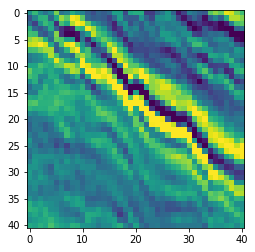

In [382]:
plt.imshow(data[313])

In [429]:
nv = 48
data_val = make_seismic(raw, n=nv)

/home/matt/anaconda3/envs/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


## Make `X` and `y`

In [675]:
CMAPS = {'Perceptually Uniform Sequential':
                            ['viridis', 'inferno', 'plasma', 'magma'],
         'Sequential':     ['Blues', 'BuGn', 'BuPu',
                             'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd',
                             'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu',
                             'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd',],
         'Sequential2':     ['afmhot', 'autumn', 'bone', 'cool',
                             'copper', 'gist_heat', 'gray', 'hot',
                             'pink', 'spring', 'summer', 'winter'],
         'Diverging':      ['BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr',
                             'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral',
                             'seismic'],
         'Seismic':      ['bwr', 'RdBu', 'RdGy', 'Greys', 'gray', 'Spectral',
                             'seismic', 'bone', 'bone_r',
                          'bwr_r', 'RdBu_r', 'RdGy_r', 'Greys_r', 'gray_r', 'seismic_r'],
         'SeismicDiv':      ['bwr', 'RdBu', 'RdGy', 'Spectral','seismic', 
                          'bwr_r', 'RdBu_r', 'RdGy_r', 'Spectral_r', 'seismic_r'],
         'SeismicRamp':      ['Greys', 'gray_r', 'bone_r', 'Blues'],
         'Qualitative':    ['Accent', 'Dark2', 'Paired', 'Pastel1',
                             'Pastel2', 'Set1', 'Set2', 'Set3'],
         'Miscellaneous':  ['gist_earth', 'terrain', 'ocean', 'gist_stern',
                             'brg', 'CMRmap', 'cubehelix',
                             'gnuplot', 'gnuplot2', 'gist_ncar',
                             'nipy_spectral', 'jet', 'rainbow',
                             'gist_rainbow', 'hsv', 'flag', 'prism'],
         'Rainbow':  ['nipy_spectral', 'jet',
                             'gist_rainbow', 'hsv'],
        }

In [676]:
import os
import logging
from matplotlib import cm
from functools import reduce

logging.basicConfig(level='INFO')

def save_image_files(y, path:str) -> None:
    """
    Make and save an image (via a matplotlib figure)
    for every image (first dimension slice) of y.
    
    Produces numbered PNG files in the path specified.
    
    Returns:
        None. Saves files as side-effect.
    """
    for i, img in enumerate(y):
        fig = plt.figure(frameon=False)
        fig.set_size_inches(5,5)

        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)

        # Note: interpolation introduces new colours.
        plt.imshow(img, cmap="jet", aspect='auto', interpolation="bicubic")
        
        if path is None:
            path = "."
        fname = os.path.join(path, f'img_{i:03d}.png')
        fig.savefig(fname, dpi=100)
        plt.close()
        logging.info(f"Saved {fname}")
    return

def make_pseudo(data, cmap:str='viridis', steps:int=128):
    cmap = cm.get_cmap(cmap)
    colours = cmap(np.linspace(0, 1, steps))[..., :3]
    pseudocolour = cmap(data)[..., :3]
    return pseudocolour, colours

def make_X_and_y(data,
                 cmap_group:str='Perceptually Uniform Sequential',
                 cmap_except:str='Qualitative',
                 steps:int=128) -> tuple:
    """
    Make a 3-channel pseudo-colour array for each
    slice in y, using the specified colourmap.
    
    Args:
        data (ndarray): M x H x W array for M examples.
        cmap_group (str): Which group of cmaps to use. (Or
            can be a single cmap.)
        steps (int): The number of steps.
    
    Returns:
        tuple: Two ndarrays, the pseudocolour images,
            and the code book.
    """
    if cmap_group.lower() == 'all':
        cmaps = reduce(lambda x, y: x + y, CMAPS.values())
    else:
        cmaps = CMAPS.get(cmap_group)
        
    cmaps = [c for c in cmaps if c not in CMAPS.get(cmap_except)]
    
    pseudos, colours = [], []
    for d in data:
        try:
            cmap = np.random.choice(cmaps)
        except:
            cmap = cmap_group
        cmap = cm.get_cmap(cmap)
    
        p, c = make_pseudo(d, cmap, steps)
        
        pseudos.append(p)
        colours.append(c)
        
    return np.stack(pseudos), np.stack(colours)

In [677]:
def display_slices(data, nrows=2):
    fig, axs = plt.subplots(ncols=6, nrows=nrows, figsize=(12,nrows*2))
    axs = np.atleast_2d(axs)
    for ax, d in zip(axs.flatten(), data):
        ax.imshow(d, aspect='auto')
        ax.axis('off')
    plt.show()

In [678]:
def luminance(arr):
    r, g, b = arr.T
    return np.sqrt(0.299 * r**2. + 0.587 * g**2. + 0.114 * b**2.)

In [679]:
steps = 24
group = 'Rainbow'

X, y = make_X_and_y(data, cmap_group=group, steps=steps)

In [680]:
X.shape, y.shape

((1600, 42, 42, 3), (1600, 24, 3))

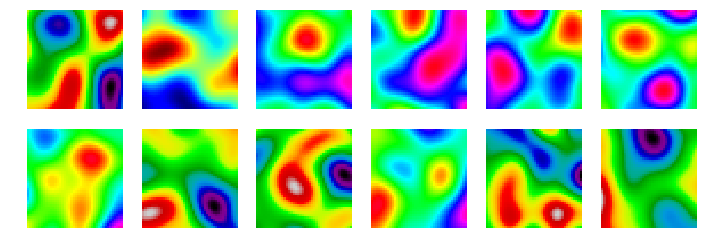

In [681]:
display_slices(X)

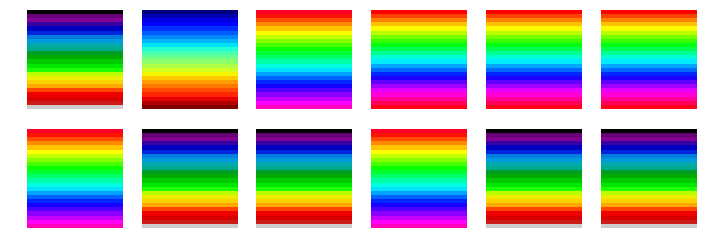

In [682]:
display_slices(y[:, :, None, :])

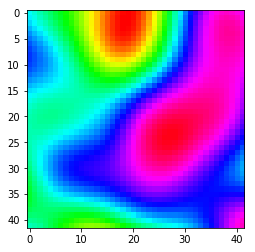

In [683]:
plt.imshow(X[3])

### Make validation data

In [693]:
X_val, y_val = make_X_and_y(data_val, cmap_group=group, steps=steps)

## Feature engineering

This is a sequence learning problem.

Want to constrain the output to only know about the colours in the training data.

Feels like we should be able to provide the training images and a code book, and ask only for the order of the colours in the image.

Options:

- Naive neighbours with shifts
- LSTM or spatial LSTM?
- Do a classification first, into discrete colours. Then give those colours to an ordering network.
- 'Lock' the colours together into a generated number or triple... but would have to span the full scale otheriw seit's no longer a regression problem. (I doubt this would work)

Another thought: use HLS space, or some other representation?

In [598]:
X.shape

(2500, 41, 41, 3)

In [613]:
Xo = X[:, :-1, :-1, :]
Xs = X[:, 1:, 1:, :]

In [614]:
assert Xo.shape == Xs.shape

In [615]:
X = np.hstack([Xo.reshape((n, -1, 3)), Xs.reshape((n, -1, 3))])

X.shape

(2500, 3200, 3)

In [685]:
Xo = X_val[:, :-1, :-1, :]
Xs = X_val[:, 1:, 1:, :]

X_val = np.hstack([Xo.reshape((nv, -1, 3)), Xs.reshape((nv, -1, 3))])

In [686]:
X_val.shape

(20, 3362, 3)

## Training

### DNN in TensorFlow

- Try this on full-dimension inputs (at least retain channels)
- Predict on data w unseen cmap
- For inference, predict on many subimages and average?


In [694]:
n = X.shape[0]
assert n == y.shape[0]

X_train, y_train = X.reshape((n, -1)), y.reshape((n, -1))

In [695]:
X_val, y_val = X_val.reshape((nv, -1)), y_val.reshape((nv, -1))

In [696]:
# 3, 6, 9, 3 w 0.125 dropout = 0.0005 << excellent on Sequential
# 3, 6, 9, 3 w 0.125 dropout = 0.0014 << excellent on SeismicRamp << without using offset trick
# 3, 6, 9, 3 w 0.125 dropout = 0.0023
# 6, 6, 9, 3 w 0.125 dropout = 0.0059
# 6, 6, 9, 6, 3 w 0.125 dropout = 0.0056

In [697]:
import tensorflow as tf

model = tf.keras.models.Sequential()

# Layer 1
model.add(tf.keras.layers.Dense(3*steps, input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.125))

# Layer 2
model.add(tf.keras.layers.Dense(6*steps))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.125))

# Layer 3
model.add(tf.keras.layers.Dense(9*steps))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.125))

# Output
model.add(tf.keras.layers.Dense(3*steps))
model.add(tf.keras.layers.Activation('tanh'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_124 (Dense)            (None, 72)                381096    
_________________________________________________________________
activation_124 (Activation)  (None, 72)                0         
_________________________________________________________________
dropout_94 (Dropout)         (None, 72)                0         
_________________________________________________________________
dense_125 (Dense)            (None, 144)               10512     
_________________________________________________________________
activation_125 (Activation)  (None, 144)               0         
_________________________________________________________________
dropout_95 (Dropout)         (None, 144)               0         
_________________________________________________________________
dense_126 (Dense)            (None, 216)               31320     
__________

In [698]:
X_train.shape, X_val.shape

((1600, 5292), (20, 5292))

In [699]:
model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    loss=tf.keras.losses.mean_squared_error,
    metrics=['mean_squared_error'],
)

def train_gen(X_train, y_train):
    while True:
        yield X_train, y_train

model.fit_generator(
    train_gen(X_train, y_train),
    epochs=4,
    steps_per_epoch=200,
    validation_data=(X_val, y_val),
)

Epoch 1/4
200/200 [==============================] - 28s 140ms/step - loss: 0.1216 - mean_squared_error: 0.1216 - val_loss: 0.0642 - val_mean_squared_error: 0.0642
Epoch 2/4
200/200 [==============================] - 25s 127ms/step - loss: 0.0493 - mean_squared_error: 0.0493 - val_loss: 0.0335 - val_mean_squared_error: 0.0335
Epoch 3/4
200/200 [==============================] - 27s 137ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0295 - val_mean_squared_error: 0.0295
Epoch 4/4
200/200 [==============================] - 21s 106ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0279 - val_mean_squared_error: 0.0279


In [700]:
y_pred = model.predict(X_val)
y_pred[y_pred < 0] = 0
y_pred[y_pred > 1] = 1

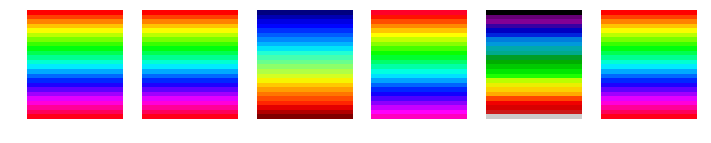

In [701]:
display_slices(y_val.reshape((nv, -1, 3))[6:, :, None, :], nrows=1)

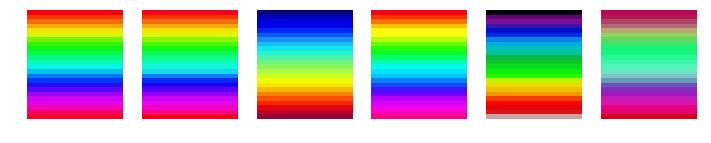

In [702]:
display_slices(y_pred.reshape((nv, -1, 3))[6:, :, None, :], nrows=1)

In [703]:
np.sqrt(mean_squared_error(y_val, y_pred))

0.16637908485385744

## Side by side

### TODO

- Rainbow detect.

In [525]:
y_val[0].reshape()

(72,)

In [653]:
41*41*3

5043

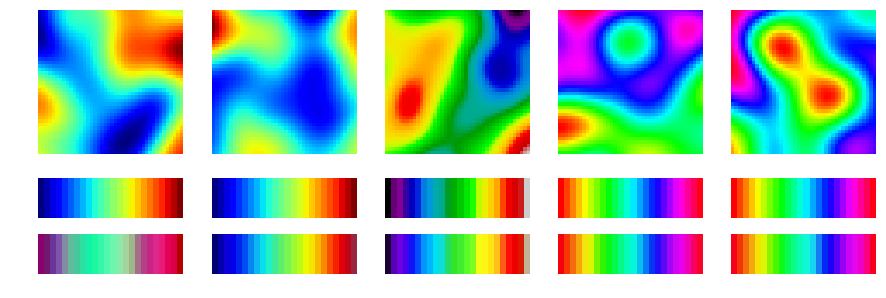

In [713]:
offset = 3

fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15, 5),
                        gridspec_kw={'height_ratios': [4,1,1]},
                        facecolor='white',
                       )

# Reshape to (2, 40, 40, 3) for stacked

for i, col in enumerate(axs.T):
    col[0].imshow(X_val[i+offset].reshape((42, 42, 3))[:,:,:])
    col[1].imshow(y_val[i+offset].reshape((1, -1, 3)), aspect='auto')
    col[2].imshow(y_pred[i+offset].reshape((1, -1, 3)), aspect='auto')
    for ax in col:data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA3YAAAEqCAYAAABZfsIoAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJztvVuMZdd55/dVnbp2VXdVd/WN7G6ym02aIiWKtClKsqQ40swkRibyYGAniANMEGCQ2C9J4ACJ53UegkGAPAUDzACJkwCThxiYGBmPjdiyLcg3amQxtsSIF1MkxTvZ3exLdVd13S95EFz7v/7nrI+7yl1VvePf72mt/e2zz95rr7322Wf//+sb2t7e3g4AAAAAAADoLMOHvQMAAAAAAADw14MHOwAAAAAAgI7Dgx0AAAAAAEDH4cEOAAAAAACg4/BgBwAAAAAA0HF4sAMAAAAAAOg4PNgBAAAAAAB0HB7sAAAAAAAAOg4PdgAAAAAAAB1n5LB3oMbQ0O9L7afK4Mm5pvw5++AzlXJExKea4sTFm0XozMy1nfJszBexI7G0Ux6LtZ3yeKwW62WxyVjeKR+NhSI2F9d3yg/Gh0Xswfhop3wx3topX4j3ivVOvLXSVN6NkmtSvmkx+VhsWEx7x5TFtC6nI07YejNNcXuuDC3MjDbl3tEithRHdsprMVbEVmO8GtuI3k75K/HnceCcG2rK3v8+E/XYTzbFK5+aKUKvxeM75R/GTxSxt+LSTvm9uFDEPowHdso34uROeSG8rSd3ymub40Vsc6Npz9WVMYs1HWTdYjE/0ZSvyPL3y9XiLyvliIjvS/ntbQv+hZRftdgHUl622KiUT0v5s7beF5riVyz096X8H6wXoX/74W/ulP9O/EER+1J8e6f8THyviJ14SS7Ez/ix7i+/HE2ffd5iL69JZcGCd1vG7lpMx5x1i20O3ke5rH+MnsYJi2l9Mon553Sb+n2+T1pfstgdKc9bTK+DoZ+1/ZJOtWSDwwfST/+5LH+/vGD+S7lXHC92JOKVeHGn/J34wyL2frwTNU7EqZ3y0/FcEft8/MxO+b/f/kfVbewLQ9+VyisW1PHAb4Z637xiscXkC3V8m7bYQ1LWMfhRW+8JKT9t3/zwTtlHszel7EejR3Cr2F7JWrRjLKl7TFvBfx7UWivbfobvv9b9WLUd/OeOttc3D3aYjRg6KxXvG09XyhH6Y2Gj+BER8bL8TnoxSl6Q8vctpusuXJLKk7aidtkLFjtbKUeUJ3Y06uj47yfyZhLTut9fss6e7deJStmP7UIS6+lvDx9f9IBuWWytUi7Zjn9YjSm8sQMAAAAAAOg49+0bu/KfdnuVtFIp+6r+Buoes9H3N3K7/596tmNH5F+X/rcp8wNjy/KZiIiYkobwv8/GK+WIe9NGuo1Vi0l9yP5ZOSp/14yNl/+tHZ1oXgGs9uwtkrT7pp2D/nNysLwuL1wfy95yzlhM3maePXa7CC092PxP628oFX9LrG+G5+W17XzMltvXt6M9ezsq9bXx8jysyr54v52fbr5jZUT+/vLrVf/xum6xk1K+MlTGVi5KxTvxMSn7KyG9bs5J2d7Y6R+jiSrgkYd/WIQejTd2yv5WXd/Gn/jQGuJGHBpfzoLSHV6etVivUo4o34b5daCHnr0Na7t9/+c1eys3lsRqf3NuWV3/UM2GfO962g533ragNMqoveqbkDd2j8ny98sT8l35R/jrtmOPyl/xS/aa8YS8uV62v7/Px0X56k8XsdH0r/j9Rv823837qezNW/Y5Xfe4xfSNnb7iKF9/rEn9VTs/+gbF367oG7v3LKbvBPQOumW/7LQ+bMPlhNS9RfTFhR/12cp6ERFnpDyWrKfb9O9u+zbPz7724OyN3cGjR3jGYtqHvN80N5wXrFW+JWVXW2h94XEL6st3fUHob+wuV3YxImJSx5HstVnynnZTfghlJ8tfcLV9m9d2KPB62zeO6UazL/De3lYt0A7e2AEAAAAAAHQcHuwAAAAAAAA6Dg92AAAAAAAAHacjHrtyhq9YEX2ye3Yy/53UdUa/iNy3pXX1OPX61msMIpnXa8yEv+pxcu/ccjE7ZONxWjXd7brYn0b9rI5Uyrsh88Kotcul1opp+9VzN2Hev4kRMaj03KySoMd3urrWvqEzmp34URmbq826FFHuq/nvHpxpxOZrU26SbPB+pR67W+KrW+zzcR4ZWI4o+7vHdDZN3+aRmeb6vTbSdJbFlVPFeoW03D1256XsMwy+oVOsugheG9P9d9rwso1P2Wqfq5QjYvSZZjxST11ExMV4e6fsHrvTcbWpXIsS9xccII9IEx2z8UG74owNad9Wi5f71bJxeLNSdvT7/BRnHgjZlwu2z+rMcpurOjP1juMzEb6sx+rDvF6Cftz6uRuvWVBWHjG/hV526rH7Vumxe0Ua4qtmpp6Q6+CpeLaIzYVdk5XYlF3j432G7YNjRTxKE7vy2Km3xQdh3Y77WnRd90fpDIeNx+6qzHQZEaHzeL4QJVr32Q0/0o7qPic1uqmHM7HlbNo9el3GngUzoV1rJlqN09afMxfV8Uos8+n5BIN6ptpOrBhRnkX31PmZO1j0CP1ENv1mw2aBf15a8Bv2qd+T8vf8Mv6alN1IrXWdhLfn45I6PLNZZNtecxFFO/TkjJyyHnBKRuuP7cakg3Lmv8umU3Vq10zWwXzomdEevpsv0x6+i9+7FXhjBwAAAAAA0HF4sAMAAAAAAOg43ZRiqroqm+o0ia0vlplrl2YbvctYr/4KdUx0hyOJjqiXxjzdQTNt7GrUp5RfK8qWAkDOZJ8Usy1Z6gOXFe1lm54KQWVM2T77fmXyLeVvtVzvHqLpKT+w/ZzT3PMP2gc1ZoncJ0QFdPqxq0VMZcLe57RfqSyzX1KpUszyutB+5jFNceApFIp9EYnQ0tnyu7fmJehSTJVf+rWsfeLKsTK2YnVFd1Olnp+x9Z6plCPi0blGfqnSy4hSfnkmynNVpDhw6eXtODRmRfkxYkl7vyQKEW9VlTW+ZFLM96R+J5NxO5UUB54b90KlHFGeShc86TFMJwmKP5TsGi7F/LaUf8clqCqH8+TlWYqGjbeb8si5MjYqGzop18+J8ssXbjbX4ws22P7tRN7zUDxSjQ1J8npPb7B9iOkOPpD/pC+Y5DGfHDwTBmobZdmL6zK6N2Xwdrnl85VyRMT3Ra22/ZQFdTr6yxZT9Zor3pTsd5Eqxq2zb4oS7yPPAy9jVtt0B1k6hVOWV2RMdnQ49XiUHBWR9XG712VNtP/oSPWExZqT/LLts6Y0+G371MuaxuDnLKj1n/EfUbpV7amv2nqZ5jGTLrdND6Id2pO2y03ylMXGRJ/sA3RlE33sJut9W9bkh+wJG8d72ia+Y1mC8kzSORje2AEAAAAAAHQcHuwAAAAAAAA6Dg92AAAAAAAAHec+9tipr27BYuI5mC/1yIUvx6dIL2Klhn5huvEn9ObqJhD1vLnHTn1FY32Gsgb/3JL4CddMq7wpp2gjScnQGpdaa90PO4u13b72sN3ssn6f+/u0abPjOQSPnbqqXEW9Ll161D1V2t09Jhs6ca1sjLXTN3bKnmJD++OkXDOeUqO9x6783Lz02/FEB659delMuf0ri5dkg0NFrNC5Zx7PWavr53yE03UvStk9dlI/8akPipD66h4szJGlr24ubhSx9By3t5DcczKPndZnrS0fkr8FvfnUtnPbr/tkHFD3xbHK8oiIh8SOM2Fjk9az43E2pPtNy7E+aMd9R9Z7yY7lPb2t+N+mWvc22FJDnvnhetL5J+QaPF+uFjebzv2y+dIvysDoNq2R5GeAeuwW7N70yiF67NRWM237NReNt2Wkb1zKfC6Ke4YaM9uWeRLfkp6qbiX30amr6eVsavrnLKYe38xjN5mY5G/LOfbD1hnt3UeXmNKufa8pX7XxWa/XLC3CdBErjU3Dxd3UB8j6VkdkO0cswcHZPqfwQaKtUnrGbolPNO03lyz4C1L+RYs9pakLfivZatNrH4iPi7V0j90pp7iDVxMjuAVuoUivol7Dq7Zmkk5h5smmfNYS12R2tb2kQtjjPB5919mJmcHliIieXrtZX28Hb+wAAAAAAAA6Dg92AAAAAAAAHec+lmIuV8oRhTTTpZjXK2Wvm3xrXaSYCyOlpGFzutHNjPUaHaDLz1T6lkklxzxVQSKxrG0nS6fQJ09crZS97m+AdTveU1R6odvw3W2bxmA3+1X7bo8dMt5r1+V4R7P99tjdSjkijmxKSoNeKVlWGa+m2PB+O1mkRSj7psovj9j87bpN74/abzM55+LZ5rpbvG76pLZSTJcL6bre/05K+aKUfabli41m70yvlIicTuSWs6L3PrpqEvLseLJUI/uMSxmVka3B5YiICbnWHzEV7UpL2bVLI3VfirJ/d2W9iIhxqQ8lx7Zt+7gq9UyyeSFJAbEvDOnAIcvnfMXmpnbVbn4vyPV51/7PPZ3cS67Jdfy2XUyHKcXUK9Iv/zEZY2YsGcZwOvm+MlXUtkTS97GddVUvfl/K37Utvqzqq69ZUOtftthTOji8aUEVvSV67hkR0s2YsPmsTMveNmVCRGyKxu7mB/VVMyGZno3hPkGfHo9r3jKBZ32bh9djI8p0B6WmVvvQi/apP9PL7mct+PNSfuoHFvwXUv6NIvJwvLVT1u72dJRoT8m6hqsOtVd6j31R5J5/IZ9c35UEUfbmlKWOuCkN5hkass23tUPcrJRtt/pygOigNWUx1f5Pm0xTu7dLuCvwxg4AAAAAAKDj8GAHAAAAAADQcXiwAwAAAAAA6Dj3scdOdeV3LCa+lsVyOtsipcEuPHYx0ZhEVmxi182NppnGJxrB69pEKdJV/51740r/Xem+2kvqAvc0jWc+Om1K9/Yk/q3U96M9525luZN5/3y/9JS7vF5jWSqEQ0An8z/qMbWvjVtwQsq7mB6+t9H0g17P+kTU+2O5+eZzWQqPXtIhNu3EL0tLHBVP7FFLXTI71Vywi2ftolwUR4T3AWXC6pk3VL/ifKUcEdNnm8HCfXTZ8YyJcH9sxYxh2jez1CIHzIjYULwpC4+d+c708DbMY9dnl6nQl6qgksZgxLY3Itf9sDXzcGLNUF/dphluhuTgp+Uvz0XrQ+aAKNmqlCPKNvH2GVXvqV2r25VBtc9jp2evvJZeloHybpQnayrqhkL12H1s/wNv9d1EDw61tvg07OrvGTU/nLbycGKq2TITzG3Zzhu27puV8qu+0Wcq5YgyxcFTngtFnXu+VT3azJOkeRFsWvlJGVyfeLyMaUP7bPRiwHKPXW1W+d1P3L6XTzYX9pa56vSMZ56x/aE5B2vxQBHJMk6sq/HN/ZfPal/xlAaNr+4L4qmLiPi6lL8iZffYzchvrWG/XMT7tW4/dq5IzD2D2hOn5Ub4p/HnxXqrhbnMr/ITlXJEnBDPqPdZ7UZ+PLU0Bt71xiplr3sH0yHF/Xdl3o96DI8dAAAAAADA3wx4sAMAAAAAAOg497EUU3HdynI9dl1eve9KiinlkVKqsr7RyDDWpxtJy6hJMVWmuTlVyi3HRIe1Zu9aN0TuspFI5kYSWdzQXuWW2YzCKpNyqVit5/juZ9vI9kvVb65MEXnAun3ujhxDn1LpALgo5XMWGzotFVMQF4oh13pJfdtiS+ONuGjN9J1ZX1JUbjmWSF5czrkm63oqhEm5RjPpotYnZsvYyqzoFU5GSdtUHJkUs1aOiOmpZl/GTN+r6SJcEp3JVYt92U1akH1GpYwueewlXShLCZChEsueyRVVYtmTfXF5ZSbFzFIcqPxyyHSnKtMcqc+gXgxH73lQ99PHYa1vmxZn5KJUbMe2pHO4vFPRTd4sdUAqm/zRrnJt6L64tujgxWx/hd6qfEbzE0lsRPZ5JLnoViwtiwoeXd2lMckAEAsum9IZ7m2G9nhSKy7GUzFbWymmd2BtCb/Ry7oz1i8vyEH4PUtWXbIuuyhdLFO1ad1lk8NF3fvaWhKblrXKmEpE/XD2n2Zf7tr5ydIDpP2mSKrxfBHRlAaeJeHnpPy0/tZy3aR26KTbjHq3kX0+/dkydrxyT/G+8Xz8vzvlrb6zpYLOMqVJTMsvr0wq6V+onaMmy4woHzk8f0Ym05yulH3dTML5M9EK3tgBAAAAAAB0HB7sAAAAAAAAOg4PdgAAAAAAAB3nPvbYZbu2XClHOUX6fBlq77GzmFoQNpoV16dLsfDmRlPvjZRGj7Xxxv/U1vsU4dPNDy5HRDmVuk/5n8XUbuE+t8wf1xb9nH+3fp/76ET3vXSzDF2Vz1mo6A1fiYPnp6R86ZIFH9OgxR6R8kMWe7ApXj9RCrBviJNwyXwhS5JyQNMRuFcuS4WQ9dWsP2qqhSIFgAnbtX5kuryWV2bFxDVr8+lrv838n34ta/Nl13yCtpf7ZdXnuDZR/m82Oq5z+dtGvX5IuF9Nq56hYzzxsinueVPvXM88feqlq/ntIiKGslQpip3XEWnnbevakjkkNuTUeSqHl6R8x30aajX1LD1qIR1/zoJist0sp9qPDem0Lds87/hZZ/dY5rE7vE6bTaGf2WOm5b/sURsvlWwmdL/nqHut8N/5lOZnK+WIiEm9AbqLT52cV5JY5rHLYrpNO7oT4rFLvD+bNjjcrXjssnY9bv1prGjAxPRqO7Ym98QP7N2Fpqros6vtO5IqyyJZny36iv82SBJsaOoCH22e0rFJrXkv2IraYInHrq8/izdv3D73uS815bsyBvt19a70lnf6nIePStnTd8i1NGWTEmTdSE9KZkltmwrByVIaTCWxPViZeWMHAAAAAADQcXiwAwAAAAAA6Dj3sRRT53/3OUUV0+ioLMdfoc5XyhHtlSrKRrlfWyLvXF0p36eujksqBPsCrY8kWhuVu/Wtt1Epe91lS21lmm0lQNl3Z6kW7D38HZFivm/7dU3KN8pQoXY6DCnmY5+Rims9tP4p/2BTXH+sDH0408hhbti8//OiKVbpZUR/+oO/LqumEVBJYibnVDwdgNbHenaiR2TdERsD9BK6F4ow67d6TXo7quTV5a8LcbQpjx8tYlMzIhHxlBZ+bRwgWy3/3svSCGQpB3YjxSzSGKisMUsdsBspbjK2qzRT5ZeL9hmVYlr2jlJ+6bEl6UfHPm9B6SurlttjSU6QHrcPfgWZpDJrlEQj7NLC89n3HxzZFPqZ5C1TOO1GfVWNZVOam9o2F+NlsbVKLEsPsIsWy6ZhT6ZvX5OhLrnNF/UTfRq0RlI5Yg22JX12w/qsyi/fiBIVK/5cHDT1VEKZgi9fsS4SThICxLAqeF+plCNKpaefPN0XVw8vVtaLiHEZR574dFP2c6X1D+KHRWwjzQEhO3rCbrSZHFKpXVa2+fRSysjSMGTjRkt4YwcAAAAAANBxeLADAAAAAADoODzYAQAAAAAAdJz72GOngv5jFpuMKpmfTOuZx85tBm1bSXxAaxOlL2dzpj7dvNI2FUJfuoO2Hjv3yWRelSzdQS39QbZ99xGJDn/J0h3cELuVS7tVzu0xn2H8wPnbUjavXFG32MeXmg74YTxQxK7FmZ3ydfEdREQsi8er3wM3uOO6z21chOF9/arYXtk39fv8u1fFl1Z68eoXUxZL8b7Ydvr7xLqycLs5H/MzZW4U9TXesPOhsXnLqTJ3ounko+6P6pvj+uBQq3Av8co56qvz9bTuPjqtj9i5qvrqvH2y8a6l/9LTHWhdfXWvWrqDb+uxuo8u83FP/vtNedjmB1+XaeXdY6ffod6Y9237PhgWZMZDaaRJi2n3dk+de+4OkLFK+a9DW3vMwX9ZdoS1lshMPLuItbXmJaG2diVP5KCeuzHbryz9hNrC3DL2YhwmzV7PRDnQahoOt1gtZBbLmXa9P7XmZSbIJBNGdXuOjxOSsuEBSfv0qGUf0YQGL9oEEB8VA+G7USL1s5ZXSj923D5W898l/X7IfrcObwwufxJbyU+fLFaDN3YAAAAAAAAdhwc7AAAAAACAjnMfSzEvStl3U9/tmiwzO6KVSjmifJXsEpqaiiVRtGxZuoO1VUl3MF5qgNpOFX/gZHInJZNstoxtWGy5Ut5N7FD4e1K2OYZvPtZ0kPcs+FE8uFP+UMoRpfxSp9OPKKWY3o9UVqnlMZM1qBTTY1n6DZUNL9u0/8tyXWpKgDUThWgqAb1GIiJiRTSCmax6N1Ph1/qx6V9WrjRjzPWZckDQ8+HS2Ktxeqc8Z/PRz8p2zs6ZhuMQ0x2sSLdx5aL2qEyWuZuUBsNrg8s/3plKue15dJKZ/T3Nw5qo51WK+bxvU8+Va7+1qyybBmnmi1Ip+02siDTztu2YSqBel7JLMdMGU5JGsd0q5Jf3kRQzm7V8P2SaGdXvy7IW9F3vqgvzhtWYSXgLNCWAC/r0c2eSmH1320wLLWWZvolbUvZz1TbFhM+0r9Pku/TyhUE7eGA0usaJ4sgjHpILz1MTfKTyQdernhNdo/WNm+J16VNRavfIsokp60ks6+uJvHPkg6Z8wewp2g6PlqH4qDjLb1pU1u59UIbOnGvKfinVPD6+/4nsVOWXEzYEp+NSMlzvRSLOGzsAAAAAAICOw4MdAAAAAABAx7mPpZieTV5R+aW9R9ZXzNnRZTPptZV9ZXLO6XK/NjcaUdNGIsX0mQHL2OByROQSUa276lO1V6sW04k9fZsblVimKvU2l+8bse2PSsyVAvdxp413/lYzu901k7x8WMgtH6jGbkQ5K57Orrhk0uO1KGdfVVRWqXLLyVgq1jsiAtYjFhtLhADaB11iqZLRBbkoXUqq9aVFmxYrkwFlsw9q3fvcRCWWyKqvzZbn8eSZRmJ50uSWWj8T14qYzqA5e7qUYk4cohRzMbmgtLlGEimmo9LMTKaZSizbzvSbDQgW25JuumG6U20HLX/bt7lQKXt94qsWlFlSV00Od1dmfvb+rHqyH0p5eTca5OQGoUOKqwBPJDGfVe4A0V1pO7ndoHotln3ORY7TtdhupoC8LWPfjIvxsukIfW/+Cj8C7W8ubLvcFJdPlSGVAbrmUdWEe5Ri3qysF5FPTKjN957FdCZMl2LeeHzQHh4U2oClfPCy3BuetE99NzugZ/V3cvmb+dV4rfJtEV+QySJHVM35kK2YnWM9mdmFlX1OOoArI3VX/Io4KjLThb6j0wazcfaSjBbZ742s00ps245tK7ln3Ys5a9vCGzsAAAAAAICOw4MdAAAAAABAx+HBDgAAAAAAoOPcv3alafEcZHYBn5+7KngfsG6Ntv47tzhs1GOrK40XanOqbPZV8Um5d07rq6K2XXXlrVqt/Dg1NmUx9dVl7ZzNnp15YQqTTv1zR2bK0Alpv2Xz6GhKg2yXD4Pfi5/dKV81fbdOhe8+Oo2ppy6iTCWwZGkFlJ6lJhiXk3tUzD/TZgxSj91Ri9V8ehHeN0uvn6Y7mBcXTJ/HbrOpr8+XsbheKX9SLPPYaQdZTNbT1CWz5UXz4cnGDznbKw1RmuLgtJlSNDY7VX7u3InMR7O/rMjfeyP2V9/IVlPumX92SLxyw1tlTOvusSvq2RjaNqWBk4w5m2LY3bIhVH113xlqyu+5RyRLd7Ak18HsFy0o97TV8vovLjs3DWmKg5vaYG7Gyxqs7c3POFIpR+R+6n1GfXWZ5y3zq2SzvPvnsm3q6KD71Svtt7Gpw8G7thGdvf3ZyxbUDujfXkt/4K2i9yIzUm2K8eyVMlTsl++zDFmj5hGu+ePcSqxeOd9j/ZyPjtqUb1hMbWirT1nwy3GIaAOWe/14fG6n/LS9b5mTGftveL6GX5BzN1Me3Kvx+zvl563ln5Zr+ennJODez6zr3Uxi2QVT2f60jbNn5XNu/VOX6Pf6Oq32db8+ZMeeeq4MrbX89ZgY4vTWtmTXv97r3K6sm/Gf6DUXbQZv7AAAAAAAADoOD3YAAAAAAAAd57CVa3U+J2WfbjSb6lrrmUbDlSltUyMkcstMprm+0rxs9anhte5SO63r1PbLtt66vL8dPRYlKnN0LYS+O/Y2yGbPruFTouvn/LsT+eicyHxGy1njY0TTJNgmTcx34HxDpJi3TFKp8kud+j4iYv5us+6iSxJFxhsbQ1FlYr2szjb6rqMzzUXkcstZmdP4qLWgpj8Y68uH0eBpF7TfqrT0uh/3dWmjK3ZsbaWYLh/JpJjKbBLT/mjr3TzZyGavPlzu2BmR1Hq6C02FMFvMIx0xO9fstEsx9huVII5sl7EJkVSOJ+kOMrllr+yW7dMYZLRN72Ljikox1yxTSDXFQZkBpKx7bOzzUrEzuSZ9f8l0jTo2+pTm72ujaOfezY1R2aMs0zOrHKIUU6VMrdMPRCm/HAnTDwtj9p93JpXSfVHh16z9BrihSjyfoV0/OG194/GnK98W0d8H/opEsvmx+R50X1zV9mplvYhCWXjMrtvaGOaq5luVckR5ZD7E6678yK/xn5SKqe3ia5UdOxDeq5QjJuSIno7HipgKLP/187bJb0n575cHtxXPy2r/qohpYoSzn27KZ7w7aTfyrqcnxU+sXniZ7lAYsj50XNbzdAe6/1eiTB30UTGA7iJZwLNynek1uJsBRr5u06X+H2ul+rG+a4d0BwAAAAAAAH8D4cEOAAAAAACg4/BgBwAAAAAA0HHuX4+dzhTtszpn3q/MZjBRKXt9L367T9ov8UktbZYa+tVe3X+nXiWdKt6njZ+facS+p+ZMwKv+jWz6d/fA7XW68do2fPsqjTbZvwqNj5no+Anx3M3ZPMg+w+xB863NRue+YF659etifvQ+3dY64xSe0nIC75XZRty+clJSDpws3QxLM01qAvffaSqEcfPYaXoFT7+hHlD1Gt64UU7zvnVFTq776K5Uyl7P0h24D3akEsvSdLgX72TTzjfOl8dzvdfU3U+o9dPFxOgR18eb2EF77FbEK7Vh7ZBZOtVHl3nsPNZ6/G7b75OxfMNiWl+0cV7rL2nA+9DdJDZysb5jG2LI8M9pH+7LfKEDQtt8O5nx0D63vJcJtQ8Xte3sJqWB+uqGkw42alvVWma5qfntIiJuvtWUtz2YHZB2zLOX6l9efMbqOl56Og31/r1qMTWzWV6BcfEMtbRRVR2Bg2J6Gbi974rERL7zAAAgAElEQVQc9/azFlRfnXvqDjXdgR6R545oGv4Z89jp4XzrB+WnFr4hlS9bQ5z6uZ3i63Zifzte2ylrF/qFL5SbOK5B9/5qn3KDpF543kcrfX14o76apzvQdBf9iYKaC+2jPvNfyyQa6mv1a06v3dJGn5p/t+X6WfygjN2Uzn8vRmPe2AEAAAAAAHQcHuwAAAAAAAA6zv0rxfyKlHcjtdrLFP0R7afPVjIZUd9+NZqmtRWTrU0Nllv+uD49MDZv+jCtHz1dihom6rPUl7ovX6+tFCpDt+HbV0mTayg1xcHpMjQksTNXy9iZ/vfyB8rN3z3XVFxbkskttb6bfptNvasqwcWm/60slsKZKyeb/rd8stSITo4387mPm6xBpZibNvd5ke7gRtM3169YLo5MbrnXdAc15ZqTaR40dtJi8t03r5RyyxvnmvoN++C8yC893YWmP3g42a39QLpG36Fq+gOXVA7LbPGe0qCo7yItzJ7k34nkfss0YZkU81Vph/f0WH0f1yrliIjJU1IxIeCmfLnLU3Xc6tOT124sZWOptLB/Iv+WOSaWd/GT4BD/FtYRzE/BXqYHj4jYSm5qY5VyRDlUqMDaVVpXZFy6YbLGVH+tfcM1j/rl2hCZrjGTYnpM9lOllxGlPK4UlrdXiGrd1Xy6WzfcqvGMlF1eqXWXYk7+G6n89KBd3EeyBA7N0R6Pj4rIc/HATtkP519ruoPfsuA//DmplB3um/HPdsqjli5A+ZqkQrhkOQeGVR9rv8P6LkpFO4dKMe0eol3d0x1kkl7d/KtRah5fk5v3Rl9n17r0vpmny9W+KJ3vjHXMLA+LXOPbNojMvy4fs/uNX1tt4I0dAAAAAABAx+HBDgAAAAAAoOPwYAcAAAAAANBx7luP3cRXGlH4ynVTmV4XM0Q2bfxuvB3KXqf5Tz12TXFpsUx3sDBVT2NQ89VdNzfMtExTPzZVmtnOXGjE8ROu5Vd5ddYmme9Qyz1bT70k3q63K+WI0mN3zWIfJrHDznfwp1L29sy8X5kFJpvaXXXcPi1/rb/3WWyajd5eKZ0hS7NNvxpPzJobG+WJX9E+fl12OktbsJuUBlrPxoDsWtaYt6tuI/vu6+UH5881J8F9sOqr6/fI7kVJv/+MJD66kZXB5YiIIfXPuiGi7ThcfFlSt5j66vrSHYjtzT12RYoDPVb3i6xXyhERR3SA9cFQd7IeaotP1z8VjSHyrsW27knumvuTzFPnp6f8L7v+Sf9cZhmqpUJwO5zOkj5f2qhiUz/oX67+OPft6Je39di5H0rsRD3br1m5Pj1Dg45Y2W4pvlvqq/MEAIWv7hkLPlcpR5Qeu8k/t+DzUj5oj52eIHcU6kkpkzs8KR47P9QXmqwF8dE3LPik+H2/+AsWbL7/9+J/3ymvW04q7TafN3v8Ez/ZlE/dKWPDenhZxoHE5z4m6z2UXOS+Cf0F42kSLshED69G2Tfei7/cKW8V6SE82YZ48S7ZGTnxeH3HatdqRGzKhaFpUSL6vbpt4I0dAAAAAABAx+HBDgAAAAAAoOPct1LMz800r0lvzJRTg1+/3MgQdSr1iIj16/K+2CVUi5Wy11210lYulEkxZftbJsVckunmF3qlFFMlWyrlOirSy4iII9FMSz9ic2mvTY3vlGenSt3akdPN53obpT5oc2RYyqWsaLXXbHNN3jFvJPIjny5/TF6LH79ZNpimNOiTjnxYKUf0SzMPmu9LOetHu0kloXV/vb+XbWZX/cZQUV1faa6n9fRzVtfrSbvcXuWWWcoTl2IW+7JtQTm+tuNBJvW02PxdkWJO1VOSXO9Ld+BfcjiMbNfrLsUclst5qFTw5G17L/psIk/eHB1cjijllys2VBVSTN1Hl8bp8Do0HnvC/1KdrJQjLAVBU/bp+e8W6Q724dbuQ3uiNN1vsowTbWWTbbcfUXbhbPuKD9UqXTxtvw+uiPxq279gL1JMT/sj9SFLWzAtB5fJLbNMCxlZSgMd/m/6Bp+Uss04n0oxZ34glectqPX/Jg6WrMXqqRAekN92T0f521EPvUh9EFG234Vny9i5pkNsyXd/03ImLIpHJlHwxhMm03xI6rOW2mVU7hWe4qBYT37iztg4/qSM+S7TvKzr2TafkLILLF8RGeqL0aTFeCc8N4nW7QfNjFxoX0ukvn6NS5ss2LV7q56Nogpv7AAAAAAAADoOD3YAAAAAAAAdhwc7AAAAAACAjnP/euzi/9kpX7UJP6/G6Z3yjbly2v8bc4135frZ0sdSpE24XnqJCotLW/9d37TxSUw19Yvldy/MS0qDOZ8ivTm+o7Ijk7FcrNcT48emmR+WRJft06yPjcsU9mYX2ZTusWbuBN2mxlZ9I8U+lo2inrvZE6XHaO5EY6o6c6k0zk19KF5A99h5/aBxObbS1k/kU+97vfa5LL2CbmOvXrmD9tjt5ZqMiHw++tHB5d2kpkj8d4tyLWsakx+vqqkQyvQGN8xzd5BMi49uwvwQYzI8eEqDkcxHl6WdaWsn9PQdxZdXylH66jzdgXrs3rW/Nd/TinogvAu1TlVgjdmThhgzU8pcpRwRcVMPQsu7SWmQDQBSd3+f1t1TZ76Xg0RtKN712nrgdoN+R2Yn1e92P18tLUJE6XNb/KCMbesXZCZBWW+o/HkQY4mPTr1znnRFY5lDLPMkatmtf9ekW25fsuATlXJE6bk7Zw0WL1TKg+oHibZ8W79dxEg0psiH4uEips3wonkn31HP3QX7iv/032nKPe/RDX8WTQ6Fm1F+wc1KOaL04122ceOsDH1HG/tgjLiXTDrVsF3kOnQft2viuDTtYzNl7GmxKPpPNW1L9ea9YMf9x9Im69kPEx8vnxPPnTeY/g6yvB838dgBAAAAAAD8zYMHOwAAAAAAgI5z30oxn5F541V6GRHxUTwosVKm+aHEjs6UKQGuzzSvSW9Ml3qXrStTsqLtjLZSJtFSUilmGVpX+dasybd6jR7pmrTDuKQKcFw2uRDNNidl6tyIMjWCpypYE1nlkml0lkWKqbLMVftulXO6FPOIyEk9fcOcnIQHxz8qYg9eavSWDz5Yai8LmeZh4FJDJZu+PVNKZQqrttLglUo5ol/LpLRNk9BWrrjXlAbZlPl9qHYua7xEipmlLkmu5VhsTqTLnm9VUpdE9Pf/g0TllxN2+aj8cjTToLm88kql7J9zpivlhK2xen3V5DAqxXypDMV7qpzULpTNpz80FXWsMVWK6TJGHfYfs9j7MjgsZ43SVopp+lTV27kMVOu7kYjvMyqjyrrlfpCpwjN1spLJNMfsgxvZaRX0WvXUBG3llv65sUo5on3KCT0/rkDb1P512YKPSvkZiz2uv2NetOCL1dhcuGzzINED9NacTmJNh3AZ7UNS9owQ7zYZw2Lb21Y39Hf/XanUhcyvR5lPYU3aMrsm0vQjIo3sk2JqZ/E8GdmFJs034jJN6fzPPVTGPnu+Kat8tHzCiJiS38zfij8uYuVd3MbqGWn0J0x3rLkX7CTf8bwMLeCNHQAAAAAAQMfhwQ4AAAAAAKDj3LdSzKfiBzvlMybFPBk3dsqzpgFSSZPLm1SGOH6mlDJeHWleuK6P2IxlKiXaqywulW81s2TOXy/lW0fONPs8JvLLns24pjLKZZNNqgRsxD6n23EZZU1uGVHKO/X7fD2dodP3WY/Hz+OZaGbCVOltRClJvTFeaoceEJlmOX/UAZHNItlyYrr0c5kcymO1qzvrm45uo63U0+uZFLPtzJceK/bFpy1sqV3KyI6t5WyQC6smqx6vSzGPmET6IFH55ZQ1pcq7hlzzls12+v0kpriyUGUo2rY+Q6b0y02TNepMmIt2DWRSzKpceTezYm5rI5kIaVg2Om4bmZD/WM+XoUKa+bo0xPJuNNvSKJM2UJyvlCMidFY5H1+m92P+yXbo3Iau0sokgko2wWQmO3TaSjFvJbF0v5LxuTbTpksqjyexbObLbOLTrJ1rM2Eu+heoHO5Ri+lMmC4ljFel/IrFGqHucPyoiPhXHCwqlvRBRSXd3khjA0o/RmWCpiyMh+QkvOOTgerKZ+Q327NfthXrPfWdQppZl7j6Ptekv1N1BWo+m3Ym0/RtajOb5HFcOsdzcqrMtVVs0vv970Wjf93qOyPyBY+aFFNnLTXtp8/s3Abe2AEAAAAAAHQcHuwAAAAAAAA6Dg92AAAAAAAAHee+9dg9vvraTnl2vBTRTot3zqfv1/qYpQTQ6fbda7Yx13jBrm2Uc2RvbVSmtPYpvlUL39aLF1Fogrfmy++an248Fb2pcp8V9bItRuntGRMlsPvc9HNZmoQF22Yt1uex2xSPXa/8bvUV9Xvsru6UH4gypUG2X/r9h+KxU7I+kPnoXGI/u8dY5ulTMj9ZdgxtUyjMV8q+XpbS4B7Y5lIy/+Bu/LJyfLfNLzt/rnG63LKGmJTUHwfNtBzfiJ3HkZpX0uvft9j3pNw2vYGTGWKkb7vHTuvusftOY2eO532btf7sRgodxtJ0BzZea7qDEWuUI+LrfsA2o9YcHV7ft8a7EXXUdu0+up+Q8kWLqd38mDXEmBtmD45vSPleeex247mr0dZ35rGVlr/Ehm0sqqUjSNMpJDHHnWBKWz+h2qG2z9mK6p27kMROfWzBNyvlsn7ckmH41PUHy+elnPXMekKK7FM+EumxvvtWGdtWW6K2+1k7Qeeek0rdBP+OxU5Ek7sgS9GQWMvKzud5Mt6T8rvV3epvsMyIqh1VtvGE2Q4XxXN3tQzFm9LfXi98oBFFkpZJ689nT1X3a3smdg1v7AAAAAAAADoOD3YAAAAAAAAd576VYk692kwH/ciD5VynR043sqVxe9eqdZdbKpt26Ksx3sTOlLGPVZq5IhqgtjI1XzebGt7edi+KnKs30hzP5ngpF12T/fep011+qWiKg+UkpcH83VJWpvsV86p9si/Q4/beJpt472Qpmbhxpnnf7XJLPVZN83DfsVe5pU/tnsWmK2X//rZT5mb9dlcpPFqUvb6b795v9ni9lrLTstHnz0q6g97JIpaNVftNJsUcviMVl2Kq/PJ7FhPVyXYyXfvQSVugMsQsdYjUt0xLdleGo3mLfVvKd3y/dAjKZMYqERo+EnUspcGwWAP6pJhy8a7b/60XpaySSpcSZWreTIqpGigfX1R+OWFzjo+XEvmD5Ls6W7iPe1rfa94CXy/TWO4l60Omf0y23yvdJbEofTObhr2tRHQ3u6XqOJekaU9ZFZVZ/5z8UnbpdbGu6+3eTWLNt7sMMFN+7ze3RIo5Za05LDecLRvs7spZ8Vn/dSjyc1dcBjbcrKqUUZWsrh48pzknspwD7xWRN2Ta/0xhq7u1ZZL64bXKihHtO593Wm0kHz/XKuuZMvbRf6sp+7Fpl329r1/qjlpbHpeLJBvPWsIbOwAAAAAAgI7Dgx0AAAAAAEDH4cEOAAAAAACg49y3HrtCnmq68rMbzVSq8WB9E5vmv1Ifnfq0flwfG1iOiFg72dRvr4ghYWOoWG/PnqDMszPSCI9vR+M7W50t93FpuvF6jLkQX3Bv4fLdxnyxOF962eK6eIR8Zmutq/cm80klHruts+Vkve8/2gjuNy6X51E9g+4nPHKI08b3kWmlMx+dGwPaeuzcR1e7uncztX/mNWvrnct8dJmXad89dtuyfbuW26ZyyDx2ds3cvNJcv0fOuQ/2oE2EDVNi1HCPXXF8Pga8USlHxJpsx92DejW796P4Pu3b1pfVV7dh/V4tvz+wvy6LFAelrTeKoaTmt/N6zyYZT9MfiInDPXZj0nGOuvlDUB+Kzw+e2TS10X2c0GH/SNkvY/J9+W6fcj7Lr7DP/OdS9tnh95KbIKLse943smu+ZmDLjG6eRyDzE0l902Kb4jW6eTuqtPXOZeu1TWkQEXFTr101Hl22FbN0BzPa396zoPqVyoQXo7Knfgtu2zX2A03Rccb2ZDrZMz0/Put/ZYb+PrwdVnVDVyrliIi3ZOC9lBkky5O3IDeEq1F2TD1bhcfOxvhi6M6u1ba/PRzfpg7d+hvM8qkclSHyhFmsdSgatt+mW9ngkM2VsIdOyxs7AAAAAACAjsODHQAAAAAAQMe5f6WYH0k5kZicHSlf826ebjQnSzZ9v9aXivmfPWafG5fYbFNeXzlW7sxu0h/UPpdJoUSHs7JSynVWJlzbUWHR5pTNpFbXW8ZUfpa9+nYJkE513ve5Rhp3ZaLU2x49t7BTnrMdmztMeVBE+5QGPs372SSm9UyKmV3NbdMWZH14rxLOrH/v5vtaow2xx43sVYI6XylHFNLm+dnyRI5N7WXO9HtDr60U02U6rzfFDftc26PxVAhDtamdrW9vyjC2VqrqY1HWfb4MlSkOFjwoZZXimToxtmXs7Z2KOn7jkvQHPTtwlWaO2cHOSKNMyH+xyeb7/rJVOc+YnZ1R6aie0mBY5XA2ti7931L5lThQflXKPT9B2b1Q73+mcVqWdnfNm14HJs0q1m0rEcuknv7dWvfvltO1KuXrtt6ajGcu9NVdsV8HRUtmM87ftOt2W9NRqNwyU/N5LNUI3qyUI4aTH4yHN8pG/IaUXXWq5ySb3d73X1vFZ/3PsndUpb9Z37vkHpGzlXKEHtFNk2LqJrXvbdo4PqLSSJcj7lVufQ+0uNsH/dSEFBMAAAAAAOBvHjzYAQAAAAAAdBwe7AAAAAAAADrO/euxU1luz2KqxbXZpeemGgXvwlSpOl4Q9fK8mZW0PmuxBZkPemmu8dh9vGLi1xUxWN2rKeWjEvMzJ2kRUg/VLqZnLwTcmccum85e99PF45kfT0/BfGnOWz7XnINl80N6qooDJ5u2NvPYaf18EnOPnTZNdjVnfUDJ+s5BjxYjlXLEX8N/V7sQzV3SNt2B++gyz6qcu8Xr5rGbEDOAj3f7jPrqhjxTih6721zkWN3VtBX3AG0i8+dqioNF6xtX5FR+27dZ89F5XW1bfWPaxaY8fLqMDWvuAD+R4v0ZNl/YiBzEkHVu9eOp/87nBy/2w7YxrNuwTttTQ5bFNl5uyoWnLiImfAr6A6T3T6SS5RVw9P5gA/SkOJ3OuRNNJzKv+4mK9T6285N55WrTz0eU5imP6W7Jbqzbejekfsf6/YR0Fb97akuu2OGs628v98epr+7RyvKI0mw24/ka9CAy02OdzOZ40PymtN+DdnlqM2RZkpzMHqfdZsnnN6j9TPJLpzDBzZSxnnY+zzmiHru3ikhtn5dsuBzPfktp3b86O8l63H6Ja11Tydj2F2Ub3uZ6WW/1/VjTC8YO6B6bP3ljBwAAAAAA0HF4sAMAAAAAAOg4968UU+UvLpm5XSlHxITUj06V81nPisxk1iQnWUylmFpeni1TJiwutpRiZlO+++faagfaTs/u0jGtu8zjehKrpTjw/VcJgL+ZjiSWyDs3Eq1aL8uNcRC0lWL68WYzB7dNd+DU+oTLMvaaJkG3k0lwtezfncqLk/1KV2yZ+qNYz7ax0qTb6LsG20qbMx2QpR1ZWpSxxBQv+81wobeyoJ7ze6Rr0qt3yPuD9v1Exp1JMVV++Z5LXFQBeSeJFfccm5xcpZhajohcR6tjk/XRnuzMcJIKIZtrWyWcw5mm1m6oWzK4r/xhGdv4k6bs0iVToR4kw/FPpNxel72R5qOpabEi8gH6zODYKdvGqYcGrxcRsSwXvd9rVfH6bstYXRkX66YfW8/mxR+rlCPKQ/Dmqskvs3QHfQeuwjYfbOratU3x6ixGeR14SoCDZP3rTfkdUzG/I+du1GS6KpVtK8uMKOWXm3MW1K6+19QBk4msWWSHaZoMKfepjLNLrpZiJKI8Hn920Nuub/PRSvnJcrU3pPxm1GP9nV2/0AbTvXX1KryxAwAAAAAA6Dg82AEAAAAAAHQcHuwAAAAAAAA6zv3rscv2TK0KbiWQ+mSUU0ofieWd8tEo/XdabxtbmDparLc4LT6GFTOPaPVe+O/uVUqDzEd3vVIe9B01svOofrHMJmHbGBfRsZ9jrx84mYWjbboDj4k0e/hkKRofm/ALoGFzo2m4dU3NYekjWo8Cu0nh0Xa96SSW+QKL/jcU7an57/zLRYzv12SWCmGPMT1XB82w5ibIzvEePXX+72HhQnOfg9alb2wk6Q7mLVPF81rx4aCW0sBjq5JTZ+xiuV7vVFMeLtOt5P+V6o3LjRMSG7LOMdQbvF6fn1j7tm1jS24Ca98tY+qrm7bx5AEpu6fOPXcHyK/0mWcG058IoTm+m2bQvxof7JSvxA+KmN4aF/pMsOqluVBZ/gmxSYlderSMPXRu8CYiSpOP+tw8E0WWOUCbMvPzWGqp4vz7dVxLd+D7P6nnIEtpkPmmS5OY+iiv2A/Eezyr/O74j6WcmLPWzQionsgFb6K2mT38Wj1TiWUmvvQL3KjXbGizyE8Wcau4Bhvc//iIjDfjniYjO25PJaLobma+0Oea4pvmT3yhUo6IeKcYG56of8HyqTKUeQb3AG/sAAAAAAAAOg4PdgAAAAAAAB3n/pVi6ttbl2FpzGeXFunQyGYpVRnvNa+Ax+wVvco0j/RJOJc+sRwRMTHd1FcWdyF3a5vuIJNbZikNMkll25QGfVIInyv8rzBd1MaxpuzSNMXbp5A0bhchlcN6aoqTcSP5kgMgS3egdU9boPJLk7WMnm3aenauPN5x6cee6mFVdAdrm81FszBRSojXR+Qc7SblQC2lQRZrex14PZNp9slAR7OgkKQ70G3s5ruzfU52pTfSfsr2e02R7iDbjaQ/95Jr24foYoR4wIItpZh3ZSPX7dS9VKxo29e677PGspQGw6pJdAlSlu5gq1KOKPuiSywraRK2SstAbLw9uBxRyi+PmNzyQSm7ZEtlSCbFPJalr9lnfqXleq7YUsWTK7b09pdnFSglnG+KbPNdKa/GuSjJ5v3XmOkoexJzmeYJkXRVsi5ERHlwrnnL0h0ofv1rSgXvN3p4emjnfIDRlr5XO9bsjBsVPk5/hOwzvyDlNyym0kzvfNos/httsVJ2fJg6USnXsxZ8QloEDzb1jThWRG7Gxzvl7NDel6H0kkkxizdS3veydtDjM1nw+mNN+RU5nOfL1eIbUv7Tvi94rlKOKKSZfo61nimSW8IbOwAAAAAAgI7Dgx0AAAAAAEDH4cEOAAAAAACg49y/HjvV9o9bTHW/7r+T+kYv8zuU9MRcMmZ6bvUuacx9euMTTWxlpPSFxUgyJXs2pXjNO+c+urYpDTymwuYN2+dC7OvC39r0wzY3bIify9tAz13iOZs+W+70nPjozsS1Ina6T6d/wExUyhG5x07rs6UPQH11J+0Ean/smUFqUy7vpd7kTvnIXOkNnZeUCYsTtmMjYmbKjie5Dou+2daL52R+Nb8WChdXNk32PWA31jg9PmsvHTsOmmG3eym6z4nHbtTGFf3H0EfhoYtSecaCLT12muLg27aJO3tNR6FdZVwMZZ7SYFg9qm3TG3jdG11i7p3bkjFus/GnxPrL5Xrqq3MfnfqhfOyZq5QjIsTC9R/ZifzP9Haxm4wj94ALv5sE1e5jU/RfrnmLIuKuHHvmscvsUW8Uyz8o1ntD6qtxybaSmeCS2IyYj56S8lnrs/fCY1ef0b5/6ni9jk/p/SbLw5D9+Ml2JsvDUA5aG/diLvm90vtXTflxmwr/cTl3H9iNsDR4lmSm0bVKOaJsluOV5RFlM/eym13WOcqNLorHLvO1FpdnadOL859tyqPmox5WG7JN+bAs2/Hve1XKL0rZPXZ/LHe09fiaRX9Wyuax+1iu+VfLUHGOs/PYEt7YAQAAAAAAdBwe7AAAAAAAADrO/SvF1KmVfS/1zftMGdqW2JppOFelvmkb9bqiUkyVu42Y1KY3IvW+6ctbTp/uSoGaxHKvcss+2ZqmLfBUAfqefznqTErZpW+i0fHX/CoJOmkxkXKcnirllg/GhwPLP65/lOznAZDI7dJUCNIWMyfnLXRLymVsUlJujNs7+02RDCzFESlPFuuNTTWfm5wqz/P8dLNj6/NlmoS4npzbWr/19bSN7lUqhOIamrRgrR+PVpYP2K/sHBdpOixWnP/yOjk6rvI7n6v8AMmO1XdLpocesmMd0XPg7SCf65NiynWwIZ9bN7WVSjFfCqOt3NJjwyL+UfnlkEu9lEzHuke5pacqqKUxGDe55WylHJFLMeWwP22Sp1+V8metvc7rpXQ8DpbfSGLZOKv7af15SqY/f8KyCjwiv0fOmCRVN6OKRJ+FXetvxFtF7KNUU5dZIiqxU5ZO4ZTs2UMm07wXUkxv555IhosfID6pvR7rbuZ5153J9IN+QK4ZPUh+S8ou6JUOd87m9tf6ZTt3bbNFeFOOVcreaYum3Y0msH5+9CzrLrtIV7fgu39FrsExG7OULKXJmxZ7RcovSPkd1aNHRBTyyy/XY7efKkO6UZdi6nnMUlq0hDd2AAAAAAAAHYcHOwAAAAAAgI7z/zsp5q0TjRZqIUrpmNbXTFegsrUslkk2Nzfk/fCGradysWymNn/tWpNY+uvaTO1QfJ+/r9e6SyFUa+MSy9EWZcMlQKphOW9bv9hIRC/YS/qL8XY1dqFvrqMDpq1Mr0+m2bRvKcuLOC66RpdiHo1mXZ/NVdE+rbLMH2+j6XTzdpKOzjXbn58tYwuzzfXUWqbpMuG2UszdUFxrPl2fSVlq7FVS21JuO21y27lCBv1YHBp+DvTYTZ4WmdxScQmnbieZHXZNJDa3TQb2I9lPn7UslWJq3SetVMllKr/0D9Zitp7OaKnliFJi6bNd9mRc1vudXXJFW7o0UiVWNvPlL8lt6z8xWbPKLefulLFJ7bIHLcXUk55JBP00al/0W6He/mymvXFRwz35cBkbk++vKdw+OXZ7p/yBiYs3Uk2d7mhN5BZRSBBnTG83kw1ait9ftO77VZOWZnLLbOZt/+5Minm/8g0puxTzSSnbjJn6G+eUyYPP6NIAABq5SURBVDRPJbNp6u9A689Fc2YTjHpHrZL19vL8LIsl6orMLJ8NIS6pzEZnPVT/Kay/Dl2K+aZsdSuelcjnbU2VX9rMl2+da8ovlqGi/orFdGdsp3umuG8Db+wAAAAAAAA6Dg92AAAAAAAAHYcHOwAAAAAAgI5z/3rsHpSy7eWKCGwXpkr9rnqEbpiZYEG0vpn/btX0wupPUr/dqqVTKD125u3JfB/zlXJE3Vfn4uH3pbzhfjjV239gMdW1m4miz1enaNvqCTLjh6YxcK/NRSmbf+fi3FuyWjk1tPro1G8XEXHhtjSM+S8PhJFK2etmCxidbswsmsLgx6s2Pjf32Gl9POpi7I3CQ1r2W+376tnz2GyvVLovzDWx+blSIa9+vPVZMUu5p0rbwb1sWVt6ioMafj3ptafbyHx0iQ+sL3ayUo6IOLm9U5ybKlOLzPWZDw+OLfl7bzhrB2/zz0m5L42KkLWftdGa2H9WZSi5XnbZwmJ1J/PRuTUnscAVbN8dXI6I2EocHtnn1EfnHjv11XkaAx1SdWrvrF3NR3dBYr9kH/u6tNfDtsvqo5vI0uh8Ng4WtShlHrvdZA7R0+r3V4mNmkXtrLR15obLsgqU9fL8fyD3uI2+T9Y8aonHLp3TvrWpKsq9zvYraxX9nBvBMjLHYm29T1p3f/m0/Pb6oXWw9eJ8ZRMoJB7Fc/Yjalp+ALWdQj/LHJH+HmxvdN2QQexKNOOgb0F7Q+ap856nv1J8xoWPih+FT1r0aSk/VylHxLKkMXAf3fel7CkNtO47Judn1C6Diba/dQTe2AEAAAAAAHQcHuwAAAAAAAA6zn0rxbz5YKMJ8hQDSzG5U1626ctViulTt8/LhKoeU8mZyzR1enj9bk+LsLQo+5LpMFy2pHWXu9SkmO/beoX88m0LXq2UI6KQ3i1HHZ9bW1F9kE0nr1KYi/YxqU88WkoMLskxXLLjeVTmhnWZ5qhWnxmwq/vNHtMdjE808psjdh6OtpRiHjEJZ6+iNevrt5X+HVFeC4vWB27JNXTc9uvWnEiiZxu93c1p04hNSEPsZjRqK0/wc1CToPh3q5KkT1IpZZd6JbGZ882159LLM3GtsmP7z5Z0h22TPA5lM4mr5NFlgYqfA1l33eTSKxK7Kl3xFdPp/I5WXMGldZdp6jC5FXW25Fpy2eRWeZ0VqPwyS2mwWaZpKbRGPtRqXRXP3uaisPv0sTL0q1L+KRvmH2pm2o8j1g1H9D7jcq4/lPLPx8GSqcKUXPN4T6iJAjNxmoshM5mmSjM/NA3XevFJFaH5ydJvzHK0+F4n6YvSk1CTad6rE9A2sYTv/+GlRtBJ8k/YvfmVeG2nfCOVq+6CGZVm2kCrP7dqqQ/66t6W2TnQdb3Nm754V36zvGsDubaCbz1LkrFaHKvn6Hm6Uva6yC9/YL9pX6yUI0qJuOdTkEvX5ZbH5PfMvRAL88YOAAAAAACg4/BgBwAAAAAA0HF4sAMAAAAAAOg4963H7oaYVdwTpGkG+tMWNHre+SinYNf0B7cSj5379tSDpLGlzXK9rRXZT5dJqwUpi7X12PWlNHhbyp7SQH11rkjOfHVZ99B2F/2++z7OS/mixT7VFB+dKQXJmsbgctRjJ94yE81he+zUT+TNl3jsJqea8+BeOfXceTqCWfFVeGy8os3XlB0R5fWUeez8upiVk+3X4bRca0d7zX4dOVce29WJZhru9REzBrUdnbJ2dj/rvfDYaZ92j53Gzpd9c268mTvePXWHme5gU+wQQ9Yve9JV+lIhZD5Hac8tMw2sSTdasfHiusTel67467b597RpFyyoMR8msxQHSuGV8+DHvqBhS86re+yGZOx1H13msav56syopb66Xy1D8Xm57B60rDbTcl8Z/pF98CUp/8sytCGxkX8RB4u2iZtStF3OWOxspbyL2LqdH72jtk9pUKKHcNxi5efKznhT+uKypCva6PPYTVfK/u278djdCzdQto22aRiyfb5/0h3opPnZGfi+/X67UV3Tt+TOTanPWMKANRmga/fET6Sto7TusduS3n3X7onLyQ1mo5jXwS/Wy1J+wmL6o9DSGHx8qSm/IMt3kdJgSH5/Tlu7Zi7XrFfuxWHJGzsAAAAAAICOw4MdAAAAAABAx7lvpZiajmDVXlQWcsgk3YHLwzTmU7dn6Q5U3llMDb9YytZiXiQA9yrdgSoqCmWX5zvIUhqoWMR0OMXrbu8Ok5VyRPliWaawP2+r6WyznypDM59qDu6ipTS4LPPGekqDi7fl2MtQ2GzQB0+W7iCJjcuU1pMmxVSJpcsts1QIKuHsyXn29CEqzfRrTa8Tv9b0+zx9iO7XVdFDuTy0N9dIi66OlNKLFe1jLWV/fXXXPNxrKab3d6mfOldKS86EpjsoBTYnrX6QbEhf3O5ZTJRfQyZJHJZ0AVv2F6FuZ8P6+qp0oysW0/qvDTXl33E9ijaXD2lt0x24xHK4Ir8ctrmpNd3BtsdkrM3SnZgyqrjlmCK5Jr+8YOv9spQ9pYHKL6dNpVfIL79j3/2/NcVFuzfpSPRAHDBPStnbUq9dV2mpNPMhi12ux1blun7frhFNXHGlUo4okxHsRv2WTdCvsUW5hyyaXHhN6n4pbcn4v20D4VbyE7GMZZLHtqkJ/EjXkth0Zb1P2ubhocK/3UjvvivSzNVd6Ye1s5tMc8zSH7TamezcZRehS0QH51rYsu1vpedfBcue0kDll57S4PNN8TVrgxcq5USKOXe7DOmw4ZLqTFicJQRx81QbeGMHAAAAAADQcXiwAwAAAAAA6Dg82AEAAAAAAHSc+9ZjV6YYmKzG+v1wTd19P219dB6refpWFkvPUeHn2KvHLosVxhJX3t5MYmpC2U16A233OYuJfls9SC531vpntovQ5fHGR/d4vGYfa1IcXDL/3aj66txT92EcLm3THYyUbTEmymr3oY2Jd8JTIRyVjnXcOs+knGv18Dkb4rFYk9QHvs3sWvP9Up9gTwxLvcwsZ5L3D883Dbi+4cajBG337DpU3A/V1mN30TZzvrn2TpphVn11WeygUQ/cZja7eYJ781alPm+GArUiv2Dfp2kNvq3jqTeP1n3MVPOXWeCKS2toPKqod27jmsXkWvL2UqvJbjx22r09ZYzUj8l6v2Sr/bQcm2UViUlpr2EfM9VX90/L0C05B97M2pQH7rH7spS9LU9UyhERF6RsPrp1OYgr1me1yd4rQ4WXTt3tPtQMdhYNXlfRXfHDWUtitfX6Y2oo3bTYqpTr28yOZ0XuL5t2UWwVvu3s6DJ241g6vHQHn5KmXbPxUtvLf71p/3q97wePGkP9k3vIY5Cd5GX7QTOZpTTQenaB6hdkaSt8++on9JQGasC1nFfqq3vePlbx2PVeLld7RMbEy2Wo2Cvf4+zWqtbvvXjqHN7YAQAAAAAAdBwe7AAAAAAAADrOfSvFXJPXsioViyinZF+z17dLIh/06dmXkjQJKkHzba5KbPmuyBNXTMqzWCl/Umw+iYVK9vYqt8zkl/qC2OVu+sr8nMVEmpmkNIjPNMXzl98oQo/HD3fKmt7A6+c+tGPNpJimmjpwVGni7+IlNjxdaqXGE7mlpi3IUiFMJ6kQVN7Z65vnvSHr+5PWj3RfxkzDkX2HoqkXPNXC6lxTv7JiMg2fQ1/RkF9PPv39X7HHdAfD50ut35mZpgOets44J/JLT03haSwOktuJOmljKInJ34Ir9hfhorTnj6xtVQHz62Uo7ugwppe96wBvJTG9RPx8b8mYPeQSIUGlmNsmY9b+tRsppsaOWuxYEhMp5i/K4q+aqvmsHOukSVdHVSNYDrUR/7Ip3rL20lOQZY44cH5eyt5/5ba1ZXOOL0s7+61DJZYeq8ktPabDTaYC3o1AMJtUfqqyXtvtfRLZPmvdj7WUFm5KuVzzjvSq9b5vyMSlyr062v1lXLI0PfRwGdM+5VJflfe9ZbldNlKBb3b2Wq6mJ9J/z0xmaSUymWZNipmlptiFploFkh+fKkOvVsoRRVoDlV9+ygY+FX5eKEPFXmZHkzXzbmTaNXhjBwAAAAAA0HF4sAMAAAAAAOg4PNgBAAAAAAB0nPvWY6cenU3bTa27/05jm30xndbdvUR1T59+bmNDYitmQNmolCNKg4KbFbI0CYWvScv+BRpz90M20aoaOlzHrL66i2VIq5+qlCNi9JlGE/4TltJAUxxoeoOIiEubbzeV12231ADh6Q0Ob9b4H6PC6mQK/bGJ0rejHjX3q2m6A0+FUHrzSg9czWPn21f8mlHPqqdM0PpI4qnbTNIplL7XMq2JphlZPll6Ym+vSLqNsOswS3ewUlnPR0Kdct49dmJmmjtTdrjSR3eriGnqCPfUua/yILkup8Q9dVrfsL8B56XuvhD10X3bYu/pOcjSu2QpDdRq4k23LeNYzzwWvcRXt/mxbEO8QD58an03KQ10qHU7s8Ys3cG/J+X/UCzXZ+0+MittNOHtJf6e+N0ytPh2U/aP6YjSlzDlK1/xJQfGq19oypknxb1fVyrliLIPe+xqEqvZ57PJ+t351daR1PZzfifPfHrZfukx+K+KbNoAdX5lx3ZF7hvXbSu5h3Ov3rm2KRT2AfndMmfD0hm5vZ0pQ6E20Z5dhRtFD9+LG8vImsc3P1NzeEbkZ/1WJZY5T71Ha91bTJxvbpbVunuNpX5exlb30Wn9rMWya1XJzpTH9tLTeWMHAAAAAADQcXiwAwAAAAAA6Dj3rRSzlJ/VUxrsB/3Sz15lTSOTYu41VixYr5Qdbx/dhp/yLKXBxaY4a3qkmvzymXK1x+cauaWmN4iIuCzyS093cOx1Ob63okQ1M57ewLNAHDSzlXJEIdMan6hLKj1VgMoc+2WaTb1fKtnENDXB+GoixRwp+3qv13x3lsLA5csqsVTZ4YLN5a4SxExKenS8lC6unmzGhJWNZFpsV4HUpJiJbDZOlpq3E2cbjeBJkV5GlGkMPKWBpqNwKaansThIXpHh9bbFtO5yS62/5DFtsjsW1EN37V9NfunZIIYfb8pjFy12WsqlhLdApZeOSjFdhKhdfTdSTK37bsll8SW73agU86TsypztVnGJuF7wO01x+/fLkDazJ8YpvuIf/IMy+IwN9gfIryUxHd38dqD1WxbLZJqrMSO1bGr3TDjV7Nmq7dlduf4X+wSk7baeid+OJ7FsWnYlk7x6O+++RSLC7i8qzVzv20o2zX/9Gw5Viil63hEbaM/KeOB3s+y8rqZi2eQ3Yi3FQfaz0ptuU26gPT8/+nvRYzoQZqLETECctMqmNKZfSrcq5YjoyfiZyZqz85H1+7Ukdq/hjR0AAAAAAEDH4cEOAAAAAACg4/BgBwAAAAAA0HHuW4+d+m3c87YqU6Yvm1kh8yr1Eq+S+ph6ZnTTz42M1H1G+9+aqlt2H13mO8w+p766x8rQyFxTtjQG8Rkpi9Xi1NPl/LKa0uDxJN3BI9fM1aB2PJ+yVueednG/m4QOGvXVJQLssfG6Vy7rf04v6h44rauvbmxlq7q9CIvJPm/2SvPPWuHvK49HvXPqq8tSOfiU/2MVj2BExJHp5rpfmy2F9FsjMiYsJilJEo/dsGxz9mRpBJvrNb66Ocuvkac0aMa0SXMzefsdJL8uZb/U1B7nHrvCr+heBj1099jVUhp4LMRHN/H5cr2xJ6XiRrfMEy0mEvXiOeqx27JBplcpR+w5FcIFMV182T72k9JnT0o3MdtpjOrYV1o/I/6kKbqtUa+svl749a835a9+tYwdosfuf2653kpf6qLmJGz1maCzKdTbJhNQMldaeb/bkpvagsXG5KaWeeeUzJGUeYba++HKo2nrGcocb/2x5v512waRDVuzvlUfmO5BSoC9kpgSpx+Qsn0s83Td+IQWrMbuucnLNziWxNruSNuYrde2Sfa29dbs5o6e2Rz38suAN3YAAAAAAAAdhwc7AAAAAACAjjO0vb29fdg7AQAAAAAAAHuHN3YAAAAAAAAdhwc7AAAAAACAjsODHQAAAAAAQMfhwQ4AAAAAAKDj8GAHAAAAAADQcXiwAwAAAAAA6Dg82AEAAAAAAHQcHuwAAAAAAAA6Dg92AAAAAAAAHYcHOwAAAAAAgI7Dgx0AAAAAAEDH4cEOAAAAAACg4/BgBwAAAAAA0HF4sAMAAAAAAOg4PNgBAAAAAAB0HB7sAAAAAAAAOg4PdgAAAAAAAB2HBzsAAAAAAICOw4MdAAAAAABAx+HBDgAAAAAAoOPwYAcAAAAAANBxeLADAAAAAADoODzYAQAAAAAAdJyRw96BGkND/7gS+andLR85P3j5ZyqbuVfLn1kZuPiRc28OXP5ovDFw+eXY3fp7+czluz8auHzipcoXvHqPlv/l4MXvvz54+V9UNlNb/o+3tyuR/YN++2Potw33e78dGhoauPyX4r8duPxCPDxw+W/HzMDlfxYPDf7ixyp9/BcHL47zW4OXz35/8PKhdwcvX/yfBi8/9trg5Rcq+xMRtUO7cHbw8v+1cmqfmR+8fPa9wctHKn0wfm3w4ju/P3j5R5XNLJ47Nzjwm785cPGzzz5b2dI+Uemz8dXK+l/b3fLVLw1e/ke9wcu/Vdl8bfmfVa6VXe9obfnHT1XWT3Zql8sfrlwu9+gI4kJUBtR7dQDbVyrr7xP02Xw5ffaTl7fss7yxAwAAAAAA6Dg82AEAAAAAAHQcHuwAAAAAAAA6Dg92AAAAAAAAHYcHOwAAAAAAgI7Dgx0AAAAAAEDH4cEOAAAAAACg4/BgBwAAAAAA0HF4sAMAAAAAAOg4PNgBAAAAAAB0HB7sAAAAAAAAOg4PdgAAAAAAAB2HBzsAAAAAAICOw4MdAAAAAABAx+HBDgAAAAAAoOPwYAcAAAAAANBxeLADAAAAAADoODzYAQAAAAAAdBwe7AAAAAAAADoOD3YAAAAAAAAdhwc7AAAAAACAjsODHQAAAAAAQMfhwQ4AAAAAAKDj8GAHAAAAAADQcXiwAwAAAAAA6Dg82AEAAAAAAHQcHuwAAAAAAAA6Dg92AAAAAAAAHYcHOwAAAAAAgI7Dgx0AAAAAAEDH4cEOAAAAAACg4/BgBwAAAAAA0HF4sAMAAAAAAOg4PNgBAAAAAAB0HB7sAAAAAAAAOg4PdgAAAAAAAB2HBzsAAAAAAICOw4MdAAAAAABAx+HBDgAAAAAAoOMMbW9vbx/2TgAAAAAAAMDe4Y0dAAAAAABAx+HBDgAAAAAAoOPwYAcAAAAAANBxeLADAAAAAADoODzYAQAAAAAAdBwe7AAAAAAAADoOD3YAAAAAAAAdhwc7AAAAAACAjsODHQAAAAAAQMfhwQ4AAAAAAKDj8GAHAAAAAADQcXiwAwAAAAAA6Dg82AEAAAAAAHQcHuwAAAAAAAA6Dg92AAAAAAAAHWfksHegxv8w9F8NXH7tzNDA5csPPTFw+cmHTw5c3vvi8sDl7392beDyt45tD1x+9ezgJnz/+OTA5UfG7w5c/sD20YHLL8TowOXnYnPg8oiIh+8Mjp39ePB3r717beDy0d8d3NbHf7A1cPmJ9we30cne2MDlRxdvDFy+/cFbA5cvbN8auPyN+MbA5X93e/D+7CdDQ//1wOWj8ZWBy8fjMwOXL8XswOVbjw5uy3hi8PKxLw5ug7FnBm9m88mFgctPH3934PKHNr4/cPnDQ68NXn/s/cFfHBGXxt4Z/Jnhtwcu/8nNwf126vrg7fdeqnzxi4MXD/3p4OVbPxi8/MbbEwOX/3DsxODlFx8duPyXX/ujwV+wT5zt/dTA5V/b+u8GLn8gPj1w+csxeAz7ztzUwOXLXxg8dq5/feDiiIuV5U/cGbj42PaVgctPbf2PA5fPTvzx4O2M12+TZ2YGj7U/0Rt8f/lHsTRw+cTq4O0M3ayMYW9UxoH/ZWPg4u3fXBm4/M6dwdf7lQcHb/76P/+nA5d/5e/9F4M/sE+sDB0buHzr86uDP/CFwffR+PLg9t3+yuD/vD86Prgd/1nlfvwn24O384OR0wOXbw59buDyXnxh4PKt4cHrD689MnB5RMT2n50aHPiDwX1q8w8Gr/7IK4N/H3x+Y3Cb/p3BPxvis5X79LmNwb/Fxoe+PXD5ke3/a+DyrZHnBy6fWHt18A7tE8vD5wYu33r25sDl218aPO4M//TgPrX15cFjy9WTg9f/P2Nw+/7R4NMa/6b3wMDlK0M/PXD5cAzum0Mx+MfH6PrlwV8cEeM/Ojtw+eb/MbiN5n9j8HbODv5ZUvl1FvEzleH3ucot4YHhwW06ufHKwOVHt745cPlG/Nrg7WwP/o3k8MYOAAAAAACg4/BgBwAAAAAA0HF4sAMAAAAAAOg4PNgBAAAAAAB0HB7sAAAAAAAAOg4PdgAAAAAAAB2HBzsAAAAAAICOw4MdAAAAAABAx+HBDgAAAAAAoOPwYAcAAAAAANBxeLADAAAAAADoODzYAQAAAAAAdBwe7AAAAAAAADoOD3YAAAAAAAAdhwc7AAAAAACAjsODHQAAAAAAQMfhwQ4AAAAAAKDj8GAHAAAAAADQcXiwAwAAAAAA6Dg82AEAAAAAAHQcHuwAAAAAAAA6Dg92AAAAAAAAHYcHOwAAAAAAgI7Dgx0AAAAAAEDH4cEOAAAAAACg4/BgBwAAAAAA0HF4sAMAAAAAAOg4PNgBAAAAAAB0HB7sAAAAAAAAOg4PdgAAAAAAAB2HBzsAAAAAAICOw4MdAAAAAABAx+HBDgAAAAAAoOPwYAcAAAAAANBxeLADAAAAAADoODzYAQAAAAAAdBwe7AAAAAAAADoOD3YAAAAAAAAdhwc7AAAAAACAjjO0vb29fdg7AQAAAAAAAHuHN3YAAAAAAAAdhwc7AAAAAACAjsODHQAAAAAAQMfhwQ4AAAAAAKDj8GAHAAAAAADQcXiwAwAAAAAA6Dg82AEAAAAAAHQcHuwAAAAAAAA6Dg92AAAAAAAAHYcHOwAAAAAAgI7Dgx0AAAAAAEDH4cEOAAAAAACg4/BgBwAAAAAA0HF4sAMAAAAAAOg4PNgBAAAAAAB0HB7sAAAAAAAAOg4PdgAAAAAAAB2HBzsAAAAAAICOw4MdAAAAAABAx+HBDgAAAAAAoOPwYAcAAAAAANBxeLADAAAAAADoODzYAQAAAAAAdJz/D60KfRlpGD8iAAAAAElFTkSuQmCC
        ax.axis('off')